In [17]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.fftpack import dct

warnings.filterwarnings('ignore')

In [3]:
# prepare final dataset schema
gen_edm = []
gen_pop = []
gen_rap = []
gen_rnb = []
gen_rock = []

# title
# artist
# copyright
# audio_path
# sampling_rate
# genre
# original_signal
# emphasis_signal
# framed_windowed_signal
# fft_signal
# mel_signal
# dct_signal
# final_features

def update_schema(schema, csv, genre):
  df = pd.read_csv(csv, index_col=False)
  for i, row in df.iterrows():
    signal, sample_rate = librosa.load(f"audio/{genre}/{row['title']}.mp3")
    data = {
      "title": row['title'],
      "artist": row['artist'],
      "copyright": row['copyright'],
      "audio_path": f"audio/{genre}/{row['title']}.mp3",
      "sampling_rate": sample_rate,
      "genre": genre,
      "original_signal": signal,
      "emphasis_signal": None,
      "framed_windowed_signal": None,
      "fft_signal": None,
      "mel_signal": None,
      "dct_signal": None,
      "final_features": None
    }
    schema.append(data)
    
update_schema(schema=gen_edm, csv="csv/edm.csv", genre="edm")
update_schema(schema=gen_rnb, csv="csv/rnb.csv", genre="rnb")
update_schema(schema=gen_pop, csv="csv/pop.csv", genre="pop")

In [ ]:
pd.DataFrame(gen_edm)

## MFCC

### Pre emphasis

In [5]:
# pre emphasis
pre_emphasis = 0.97
def emphasis(signal):
  return np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

def apply_emphasis(schema):
  for data in schema:
    data['emphasis_signal'] = emphasis(data['original_signal'])
  
apply_emphasis(gen_edm)
apply_emphasis(gen_pop)
apply_emphasis(gen_rnb)
# apply_emphasis(gen_rock)
# apply_emphasis(gen_rap)

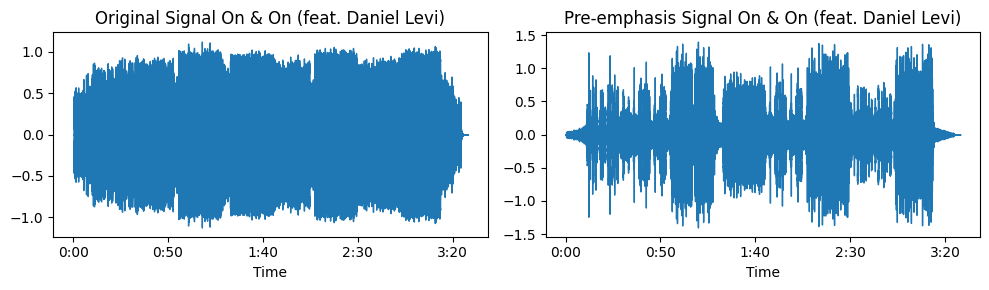

In [6]:
# plotting
plot_original_name, plot_original_signal, plot_original_sr =gen_edm[0]['title'], gen_edm[0]['original_signal'], gen_edm[0]['sampling_rate']
plot_emphasis_name, plot_emphasis_signal, plot_emphasis_sr = gen_edm[0]['title'], gen_edm[0]['emphasis_signal'], gen_edm[0]['sampling_rate']

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
librosa.display.waveshow(plot_original_signal, sr=plot_original_sr)
plt.title(f'Original Signal {plot_original_name}')

plt.subplot(1, 2, 2)
librosa.display.waveshow(plot_emphasis_signal, sr=plot_emphasis_sr)
plt.title(f'Pre-emphasis Signal {plot_emphasis_name}')

plt.tight_layout()

### Framing & Windowing

In [7]:
frame_size = 0.025
frame_stride = 0.01

def framing(emphasized_signal, sr):
  frame_length, frame_step = frame_size * sr, frame_stride * sr  # Convert from seconds to samples
  signal_length = len(emphasized_signal)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  return pad_signal[indices.astype(np.int32, copy=False)]

def windowing(framing_signal, windowing_sr):
  return framing_signal * np.hamming(frame_size * windowing_sr)

def apply_framing_windowing(schema):
  for data in schema:
    framed_signal = framing(data['emphasis_signal'], data['sampling_rate'])
    windowed_signal = windowing(framed_signal, data['sampling_rate'])
    data['framed_windowed_signal'] = windowed_signal
    
apply_framing_windowing(gen_edm)
apply_framing_windowing(gen_rnb)
apply_framing_windowing(gen_pop)

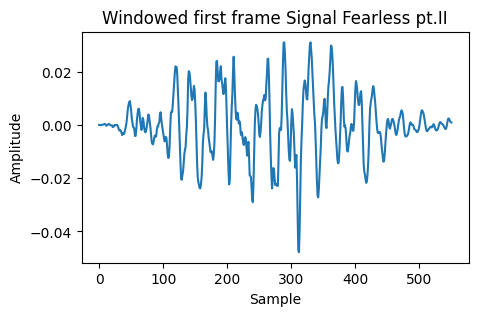

In [8]:
plot_framing_windowing_signal, plot_framing_windowing_name = gen_edm[9]['framed_windowed_signal'][0], gen_edm[9]['title']
plt.figure(figsize=(5, 3))
plt.plot(plot_framing_windowing_signal)
plt.title(f'Windowed first frame Signal {plot_framing_windowing_name}')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

### FFT

In [10]:
NFFT = 512
def fft(framed_windowed_signal):
  mag_frames = np.absolute(np.fft.rfft(framed_windowed_signal, NFFT))  # Magnitude of the FFT
  pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
  return pow_frames

def apply_fft(schema):
  for data in schema:
    data['fft_signal'] = fft(data['framed_windowed_signal'])
    print(f"fft {data['genre']}/{data['title']} done...")
    
apply_fft(gen_edm)
apply_fft(gen_pop)
apply_fft(gen_rnb)
# apply_fft(gen_rock)
# apply_fft(gen_rap)


fft edm/On & On (feat. Daniel Levi) done...
fft edm/Heroes Tonight (feat. Johnning) done...
fft edm/Mortals (feat. Laura Brehm) done...
fft edm/Invincible done...
fft edm/My Heart done...
fft edm/Sky High done...
fft edm/Blank done...
fft edm/Why We Lose (feat. Coleman Trapp) done...
fft edm/Symbolism done...
fft edm/Fearless pt.II done...
fft edm/Shine done...
fft edm/Invisible done...
fft edm/Superhero done...
fft edm/Feel Good done...
fft edm/Cradles done...
fft edm/Light It Up done...
fft edm/We Are done...
fft edm/Dreams pt. II done...
fft edm/Ark done...
fft edm/Royalty done...
fft edm/Firefly done...
fft edm/MATAFAKA done...
fft edm/Hellcat done...
fft edm/Shootin Stars done...
fft edm/Where We Started done...
fft edm/Control done...
fft edm/Energy done...
fft edm/Make Me Move done...
fft edm/Link done...
fft edm/Savannah done...
fft edm/Why Do I? done...
fft edm/Anikdote done...
fft edm/Let's Go! done...
fft edm/Limitless done...
fft edm/High done...
fft edm/C U Again done...
f

In [ ]:
pd.DataFrame(gen_edm)

### Mel Filterbank

In [ ]:
nfilt = 40

def melbanks(pow_frames, sr):
  low_freq_mel = 0
  high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
  hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
  bin = np.floor((NFFT + 1) * hz_points / sr)

  fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
  for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
      fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
      fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
  filter_banks = np.dot(pow_frames, fbank.T)
  filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
  return 20 * np.log10(filter_banks)

def apply_melbanks(schema):
  for data in schema:
    data['mel_signal'] = melbanks(data['fft_signal'], data['sampling_rate'])
    print(f"mel {data['genre']}/{data['title']} done...")

apply_melbanks(gen_edm)
apply_melbanks(gen_pop)
apply_melbanks(gen_rnb)
# apply_melbanks(gen_rock)
# apply_melbanks(gen_rap)

In [ ]:
pd.DataFrame(gen_pop)

### DCT

In [ ]:
num_ceps = 12
cep_lifter = 22

def features(mel_signal):
  mfcc = dct(mel_signal, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
  (nframes, ncoeff) = mfcc.shape
  n = np.arange(ncoeff)
  lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
  mfcc *= lift
  return mfcc

def apply_features(schema):
  for data in schema:
    data['dct_signal'] = features(data['mel_signal'])
    print(f"dct {data['genre']}/{data['title']} done...")


apply_features(gen_edm)
apply_features(gen_pop)
apply_features(gen_rnb)
# apply_features(gen_rock)
# apply_features(gen_rap)


In [ ]:
pd.DataFrame(gen_edm)

### Agregate

In [ ]:
def agregate(mfcc):
  return np.mean(mfcc, axis=0)

def apply_agregate(schema):
  for data in schema:
    data['final_features'] = agregate(data['dct_signal'])
    print(f"agregate {data['genre']}/{data['title']} done...")

apply_agregate(gen_edm)
apply_agregate(gen_pop)
apply_agregate(gen_rnb)
# apply_agregate(gen_rock)
# apply_agregate(gen_rap)

In [ ]:
pd.DataFrame(gen_edm)

In [31]:
print(len(gen_edm[0]['final_features']))

12


In [32]:
pd.DataFrame(gen_edm).to_csv("final/edm.csv")
pd.DataFrame(gen_pop).to_csv("final/pop.csv")
pd.DataFrame(gen_rnb).to_csv("final/rnb.csv")
